# Retail Forecasting

## Problem Statement:
The large company who is into beverages business in Australia. They sell their products through various super-markets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed forecast of each of products at item level every week in weekly buckets.

In [47]:
import numpy as np
import pandas as pd
import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [48]:
forecast = pd.read_csv('./Data/newForecast.csv')
forecast.head(3)

,Unnamed: 0,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum
0,0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5
1,1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6
2,2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7


In [49]:
forecast['date'] = pd.to_datetime(forecast['date'])

In [50]:
forecast.drop('Unnamed: 0', axis=1, inplace=True)
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7


In [51]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Product          1218 non-null   object        
 1   date             1218 non-null   datetime64[ns]
 2   Sales            1218 non-null   int64         
 3   Discount         1218 non-null   float64       
 4   In-Store Promo   1218 non-null   int64         
 5   Catalogue Promo  1218 non-null   int64         
 6   Store End Promo  1218 non-null   int64         
 7   Google_Mobility  1218 non-null   float64       
 8   Covid_Flag       1218 non-null   int64         
 9   V_DAY            1218 non-null   int64         
 10  EASTER           1218 non-null   int64         
 11  CHRISTMAS        1218 non-null   int64         
 12  DayOfWeek        1218 non-null   object        
 13  Quarter          1218 non-null   int64         
 14  WeekNum          1218 non-null   int64  

# Add Year, Month, and Day

In [52]:
forecast['Year'] = forecast['date'].dt.year
forecast['Month'] = forecast['date'].dt.month
forecast["Day"] = forecast['date'].dt.day
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum,Year,Month,Day
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5,2017,2,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6,2017,2,12
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7,2017,2,19


# Modeling

In [53]:
forecast = forecast.loc[:, forecast.columns != 'DayOfWeek']

forecast.head()

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,Quarter,WeekNum,Year,Month,Day
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,1,5,2017,2,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,1,6,2017,2,12
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,1,7,2017,2,19
3,SKU1,2017-02-26,26789,0.00,1,0,1,0.0,0,0,0,0,1,8,2017,2,26
4,SKU1,2017-03-05,41999,0.17,0,0,0,0.0,0,0,0,0,1,9,2017,3,5


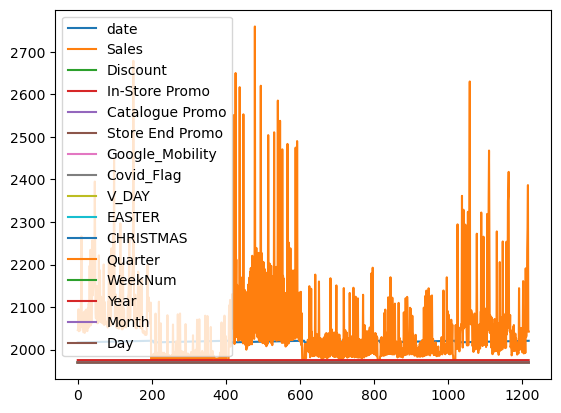

In [54]:
forecast.plot()
plt.show()

In [55]:
#Turn date column to int with a temporary df
df = forecast.copy()
df["date"] = df["date"].apply(lambda x: int(x.timestamp()))

In [56]:
#seperate by product

product1 = df[df["Product"] == "SKU1"]
product2 = df[df["Product"] == "SKU2"]
product3 = df[df["Product"] == "SKU3"]
product4 = df[df["Product"] == "SKU4"]
product5 = df[df["Product"] == "SKU5"]
product6 = df[df["Product"] == "SKU6"]

I will focus on product 1 for simplicity for now

In [57]:
product1.head()

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,Quarter,WeekNum,Year,Month,Day
0,SKU1,1486252800,27750,0.00,0,0,0,0.0,0,0,0,0,1,5,2017,2,5
1,SKU1,1486857600,29023,0.00,1,0,1,0.0,0,1,0,0,1,6,2017,2,12
2,SKU1,1487462400,45630,0.17,0,0,0,0.0,0,0,0,0,1,7,2017,2,19
3,SKU1,1488067200,26789,0.00,1,0,1,0.0,0,0,0,0,1,8,2017,2,26
4,SKU1,1488672000,41999,0.17,0,0,0,0.0,0,0,0,0,1,9,2017,3,5


# Linear Regression

 This is my base model. It is obviously not the best model to choose.

In [58]:
X = product1.loc[:, ~product1.columns.isin(['DayOfWeek', 'Sales', 'Product'])]
y = product1["Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

In [59]:
#Evaluations 

def evaluations(y_test, prediction):
    
    #mean squared error
    mse = mean_squared_error(y_test, prediction)
    
    #root mean squared error
    rmse = np.sqrt(mse)
    
    #mean absolut Error
    mae = mean_absolute_error(y_test, prediction)
    
    #Print 
    print('Mean Absolute Error: %f' % mae)
    print("Mean Squared Error: %.3f" % mse)
    print('Root Mean Squared Error: %.3f' % rmse)

In [60]:
# fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict on the same period
pred1 = lr.predict(X_test)

#Evaluations 
evaluations(y_test, pred1)

Mean Absolute Error: 12602.135067
Mean Squared Error: 418595088.061
Root Mean Squared Error: 20459.596


# GridSearch CV

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
def gridsearch(model, parameters, X_train, y_train):
    grid = GridSearchCV(estimator=model, param_grid = parameters,cv=5, n_jobs=None)
    result = grid.fit(X_train, y_train)
    
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    

In [63]:
# Train a linear regression model using grid search and cross-validation
model = LinearRegression()
param_grid = {'fit_intercept': [True, False], 
              'positive': [True, False],
             'n_jobs': [1, 3, None]}
gridsearch(model, param_grid, X_train, y_train)

Best Score: 0.4879551565546906
Best Hyperparameters: {'fit_intercept': True, 'n_jobs': 1, 'positive': True}


In [64]:
#USE WITH BEST PARAMETERS

# fit the model
lr = LinearRegression(fit_intercept=True, n_jobs= 1, positive= True)
lr.fit(X_train, y_train)

# predict on the same period
pred1 = lr.predict(X_test)

#Evaluations 
evaluations(y_test, pred1)

Mean Absolute Error: 12752.544756
Mean Squared Error: 438919569.518
Root Mean Squared Error: 20950.407


The original model performed the best.

# Random Forest 

In [65]:
# fit the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations 
evaluations(y_test, pred2)


Mean Absolute Error: 7642.115000
Mean Squared Error: 233360421.815
Root Mean Squared Error: 15276.139


# GridSearchCV 

In [66]:
model = RandomForestRegressor()
param_grid = {'max_features' : ['sqrt',0.2],
              'n_estimators': [100, 200, 300, 500] 
              #'min_samples_leaf': [1, 3,],
              
             #'n_jobs': [None, 3]
             }

gridsearch(model, param_grid, X_train, y_train)

Best Score: 0.6690692994531571
Best Hyperparameters: {'max_features': 0.2, 'n_estimators': 100}


In [67]:
# fit the model
rf = RandomForestRegressor(max_features = 0.2,n_estimators=100, min_samples_leaf=1,
                           n_jobs=None, random_state= 42)
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations 
evaluations(y_test, pred2)

Mean Absolute Error: 7616.845000
Mean Squared Error: 154867886.995
Root Mean Squared Error: 12444.593


# Feature Importance

In [68]:
# Feature Importance

#feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
Discount,0.330338
WeekNum,0.161775
Month,0.117169
date,0.099986
Day,0.072696
Year,0.047277
Catalogue Promo,0.046616
Quarter,0.034697
Store End Promo,0.030391
Google_Mobility,0.026174


<Figure size 1000x1500 with 0 Axes>

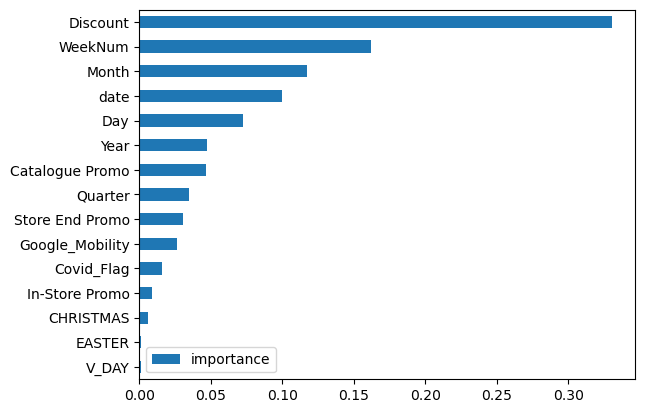

In [69]:
#plot importance
plt.figure(figsize=(10, 15))
feature_importances.plot(kind='barh').invert_yaxis()

# Testing

In [70]:
# fit the model
rf = RandomForestRegressor(max_features = 0.2,n_estimators=100, min_samples_leaf=1,
                           n_jobs=None, random_state= 42)
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations 
evaluations(y_test, pred2)

Mean Absolute Error: 7616.845000
Mean Squared Error: 154867886.995
Root Mean Squared Error: 12444.593


In [73]:
"""errors = abs(pred2 - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), '$.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')"""

Mean Absolute Error: 7616.84 $.
Accuracy: -inf %.


# ARIMA

In [25]:
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,Quarter,WeekNum,Year,Month,Day
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,1,5,2017,2,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,1,6,2017,2,12
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,1,7,2017,2,19


In [26]:
forecast = forecast.loc[:, forecast.columns.isin(['Sales', 'date', 'Product'])]
forecast.set_index('date', inplace=True)

In [27]:
forecast.head(3)

,Product,Sales
date,,
2017-02-05,SKU1,27750
2017-02-12,SKU1,29023
2017-02-19,SKU1,45630


In [28]:
product1 = forecast[forecast["Product"] == "SKU1"]
product2 = forecast[forecast["Product"] == "SKU2"]
product3 = forecast[forecast["Product"] == "SKU3"]
product4 = forecast[forecast["Product"] == "SKU4"]
product5 = forecast[forecast["Product"] == "SKU5"]
product6 = forecast[forecast["Product"] == "SKU6"]

In [29]:
#forecast.head()

## Stat test if it is stationary or not  using Augmented Dickey-Fuller Test

In [30]:
# ADF Test
# Function to print out results in customised manner
def adf_test(df):
    
    #df.index = df['date']

    # Check the data type
    #del df['date']
    del df["Product"]
    # View the dataset
    #df.head()
    
    timeseries = df["Sales"]
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [31]:
#product 1
adf_test(product1)

Results of Dickey-Fuller Test:
Test Statistic                -8.709707e+00
p-value                        3.618957e-14
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


In [32]:
# Product 2
adf_test(product2)

Results of Dickey-Fuller Test:
Test Statistic                -1.510105e+01
p-value                        7.939761e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


In [33]:
# Product 3
adf_test(product3)

Results of Dickey-Fuller Test:
Test Statistic                -5.752370e+00
p-value                        5.925780e-07
#Lags Used                     3.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64


In [34]:
# Product 4
adf_test(product4)

Results of Dickey-Fuller Test:
Test Statistic                  -5.589760
p-value                          0.000001
#Lags Used                       3.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


In [35]:
# Product 5
adf_test(product5)

Results of Dickey-Fuller Test:
Test Statistic                  -4.407753
p-value                          0.000288
#Lags Used                       4.000000
Number of Observations Used    199.000000
Critical Value (1%)             -3.463645
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
dtype: float64


In [36]:
# Product 6
adf_test(product6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.259048
p-value                          0.000007
#Lags Used                       3.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


## All of the products are stationary based on the Augmented Dickey-Fuller Test.

## ARIMA Model

In [37]:
product1.head(3)

,Sales
date,
2017-02-05,27750
2017-02-12,29023
2017-02-19,45630


In [38]:
#split
X_train, X_test = train_test_split(product1.values, train_size=0.66, random_state=42)
history = [x for x in X_train]
pred3 = list()


# walk-forward validation
for t in range(len(X_test)):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    pred3.append(yhat)
    obs = X_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=36816.428264, expected=25936.000000
predicted=40447.770602, expected=54655.000000
predicted=36665.144253, expected=119393.000000
predicted=54825.286333, expected=32373.000000
predicted=70717.266917, expected=52964.000000
predicted=52305.769730, expected=94633.000000
predicted=67722.210105, expected=33665.000000
predicted=70946.262854, expected=36955.000000
predicted=49734.163449, expected=0.000000
predicted=44191.178659, expected=23891.000000
predicted=27172.205216, expected=49314.000000
predicted=26859.684612, expected=77842.000000
predicted=38719.442094, expected=39290.000000
predicted=47259.049368, expected=41141.000000
predicted=45611.457063, expected=51305.000000
predicted=50265.807868, expected=55980.000000
predicted=51598.464351, expected=43689.000000
predicted=48416.439236, expected=31850.000000
predicted=45022.990187, expected=33908.000000
predicted=41178.859485, expected=72587.000000
predicted=44143.870561, expected=26410.000000
predicted=47875.710855, expected=8043

In [39]:
#evaluated 

forecast_errors = [X_test[i]-pred3[i] for i in range(len(X_test))]

#forecast bias
bias =  np.mean(forecast_errors)


#Print 
#print('Forecast Errors: %s' % forecast_errors)
print('Forecasting Bias or Mean Forecast Error: %f' % bias)
#Evaluations 
evaluations(X_test, pred3)


Forecasting Bias or Mean Forecast Error: 111.446458
Mean Absolute Error: 21254.212014
Mean Squared Error: 899505457.918
Root Mean Squared Error: 29991.756


Based on the <b>forecasting bias</b> the model is under forecasting. 

Based on the <b>Mean Absolute Error</b>, it is really high. The closer to 0 the better the model can be. 

The model has a high <b>Mean Squared Error</b>. A mean squared error of zero indicates perfect skill, or no error.

The model has a high <b>Root Mean Squared Error</b>.As with the mean squared error, an RMSE of zero indicates no error.

In [40]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -2377.813
Date:                Thu, 21 Sep 2023   AIC                           4765.626
Time:                        14:41:41   BIC                           4782.167
Sample:                             0   HQIC                          4772.318
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8472      0.077    -11.063      0.000      -0.997      -0.697
ar.L2         -0.4996      0.111     -4.503      0.000      -0.717      -0.282
ar.L3         -0.3805      0.114     -3.327      0.0

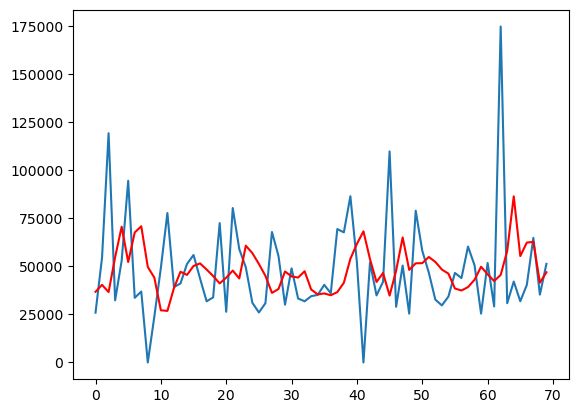

In [41]:
# plot forecasts against actual outcomes
plt.plot(X_test)
plt.plot(pred3, color='red')
plt.show()

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [42]:
product1

,Sales
date,
2017-02-05,27750
2017-02-12,29023
2017-02-19,45630
2017-02-26,26789
2017-03-05,41999
...,...
2020-11-29,0
2020-12-06,0
2020-12-13,0


In [43]:
train_data = product1.iloc[:-12]
test_data = product1.iloc[-12:]

In [44]:
model = SARIMAX(
train_data['Sales'], order =(1, 1, 1), seasonal_order=(1, 1, 1, 12))

result = model.fit()

/Users/kierradangerfield/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/kierradangerfield/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09729D+01    |proj g|=  3.58384D-02

At iterate    5    f=  1.09401D+01    |proj g|=  3.50565D-03

At iterate   10    f=  1.09390D+01    |proj g|=  1.10468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   1.105D-05   1.094D+01
  F =   10.939038971957686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [45]:
forecast = result.get_forecast(steps=12)
predicted_demand = forecast.predicted_mean

evaluations(test_data, predicted_demand)

Mean Absolute Error: 26299.801317
Mean Squared Error: 1092712027.966
Root Mean Squared Error: 33056.195


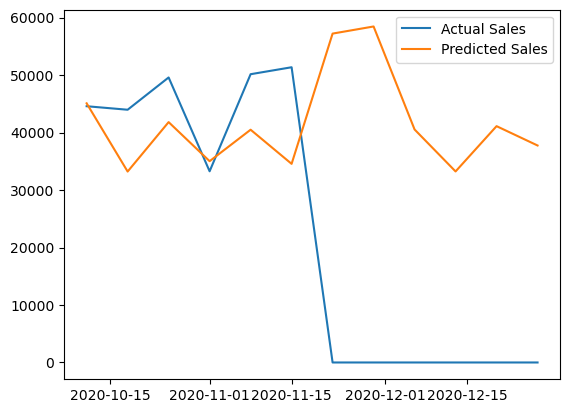

In [46]:
plt.plot(test_data, label='Actual Sales')
plt.plot(predicted_demand, label='Predicted Sales')
plt.legend()
plt.show()

# Recommendations

• Discount and WeekNum are the two most important features. 

• The Random Forest model performed the best with a Mean Absolute error of 7,616.85 for product1. I would suggest to get more data for each product to help build a better model.